# imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, plot_roc_curve, classification_report
from math import exp
from IPython.display import HTML
import random
import shap


Upload data from url web address

In [30]:
csv_url = 'https://raw.githubusercontent.com/efratkohen/Big_five/master/big_five_scores.csv'
df=pd.read_csv(csv_url, index_col=0) 

In [32]:
#Add show/hide option for the jupyter notebook. press the show/hide button after running this cell.
def hide_toggle(text='Toggle', for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = text + ' show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# Exploratory Data Analysis

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307313 entries, 1 to 334161
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   country                  307141 non-null  object 
 1   age                      307313 non-null  int64  
 2   sex                      307313 non-null  int64  
 3   agreeable_score          307313 non-null  float64
 4   extraversion_score       307313 non-null  float64
 5   openness_score           307313 non-null  float64
 6   conscientiousness_score  307313 non-null  float64
 7   neuroticism_score        307313 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 21.1+ MB


Check for NAN values

In [34]:
NAN_rows = df.shape[0] - df.dropna().shape[0]
NAN_percent = NAN_rows/df.shape[0]
print(f"The amount of rows containig nan values is {(NAN_percent * 100):.2f}% ")

The amount of rows containig nan values is 0.06% 


Drop all nan values after review that there are less than 0.1%

In [35]:
data = df.dropna()

In [36]:
data.describe()

,age,sex,agreeable_score,extraversion_score,openness_score,conscientiousness_score,neuroticism_score
count,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000,307141.000000
mean,25.193953,1.602557,0.696809,0.672328,0.733943,0.702013,0.574405
std,10.002145,0.489370,0.093565,0.108672,0.087612,0.107376,0.125743
min,10.000000,1.000000,0.200000,0.200000,0.253333,0.206667,0.196667
25%,18.000000,1.000000,0.640000,0.600000,0.673333,0.630000,0.486667
50%,22.000000,2.000000,0.703333,0.680000,0.736667,0.706667,0.570000
75%,29.000000,2.000000,0.763333,0.750000,0.796667,0.776667,0.660000
max,99.000000,2.000000,1.000000,0.993333,0.996667,1.000000,0.996667


Check data balance between female and male

In [45]:
gender_count = data['sex'].value_counts(normalize=True)
print(f"The data containes {(gender_count.iloc[0]*100):.2f}% female's surveys and {(gender_count.iloc[1]*100):.2f}% male's surveys")

The data containes 60.26% female's surveys and 39.74% male's surveys


Pairplot visualization with femal/male color map:

In [46]:
#g = sns.pairplot(data, hue='sex')
#new_labels = ['Male', 'Female']
#for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#_=g

Box plot visualization for the five personality traits by sex:

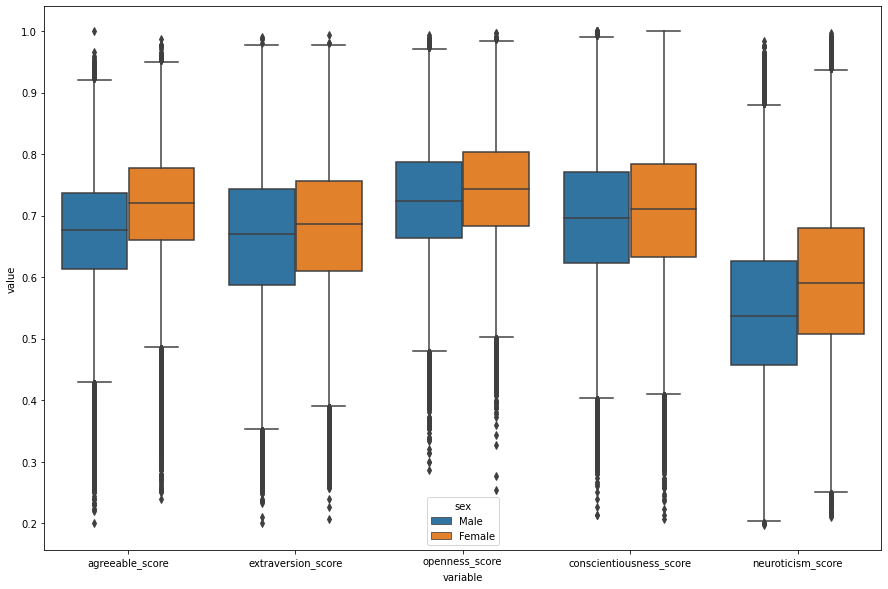

In [39]:
personality_traits = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score','neuroticism_score']
data1 = pd.melt(data, id_vars=['sex'], value_vars=personality_traits)
data1.loc[(data1.sex == 1),'sex'] = 'Male'
data1.loc[(data1.sex == 2),'sex'] = 'Female'
fig, ax = plt.subplots(figsize = (15, 10))
m = sns.boxplot(ax=ax, data=data1, x="variable", y="value", hue="sex")

Box plot visualization for age by sex:

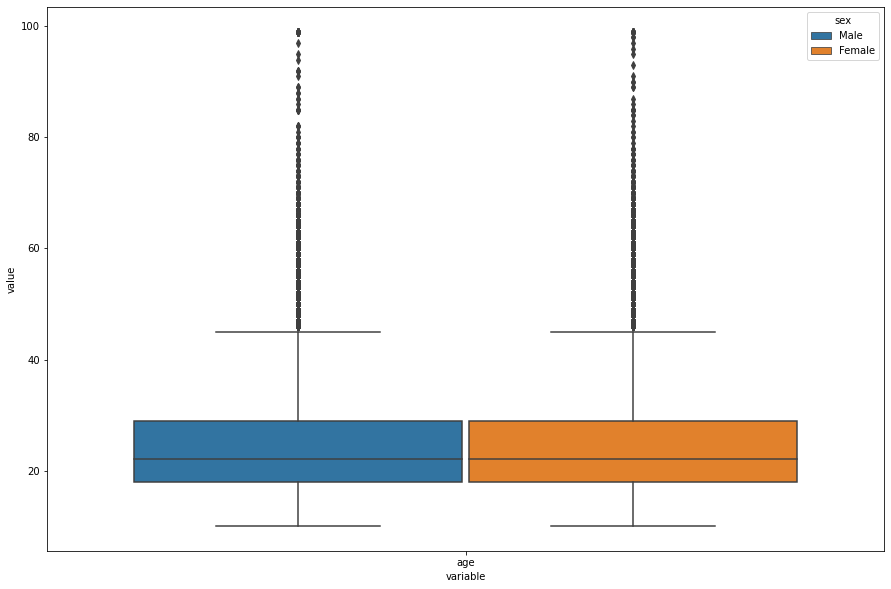

In [40]:
data_age_melt = pd.melt(data, id_vars=['sex'], value_vars=['age'])
data_age_melt.loc[(data_age_melt.sex == 1),'sex'] = 'Male'
data_age_melt.loc[(data_age_melt.sex == 2),'sex'] = 'Female'
fig, ax = plt.subplots(figsize = (15, 10))
m = sns.boxplot(ax=ax, data=data_age_melt, x="variable", y="value", hue="sex")

Calaulation for the amount of countries in the data:


In [42]:
print(f"The data containes {len(data.country.unique())} different countries")

The data containes 235 different countries


How many observations there are for each country in the data?

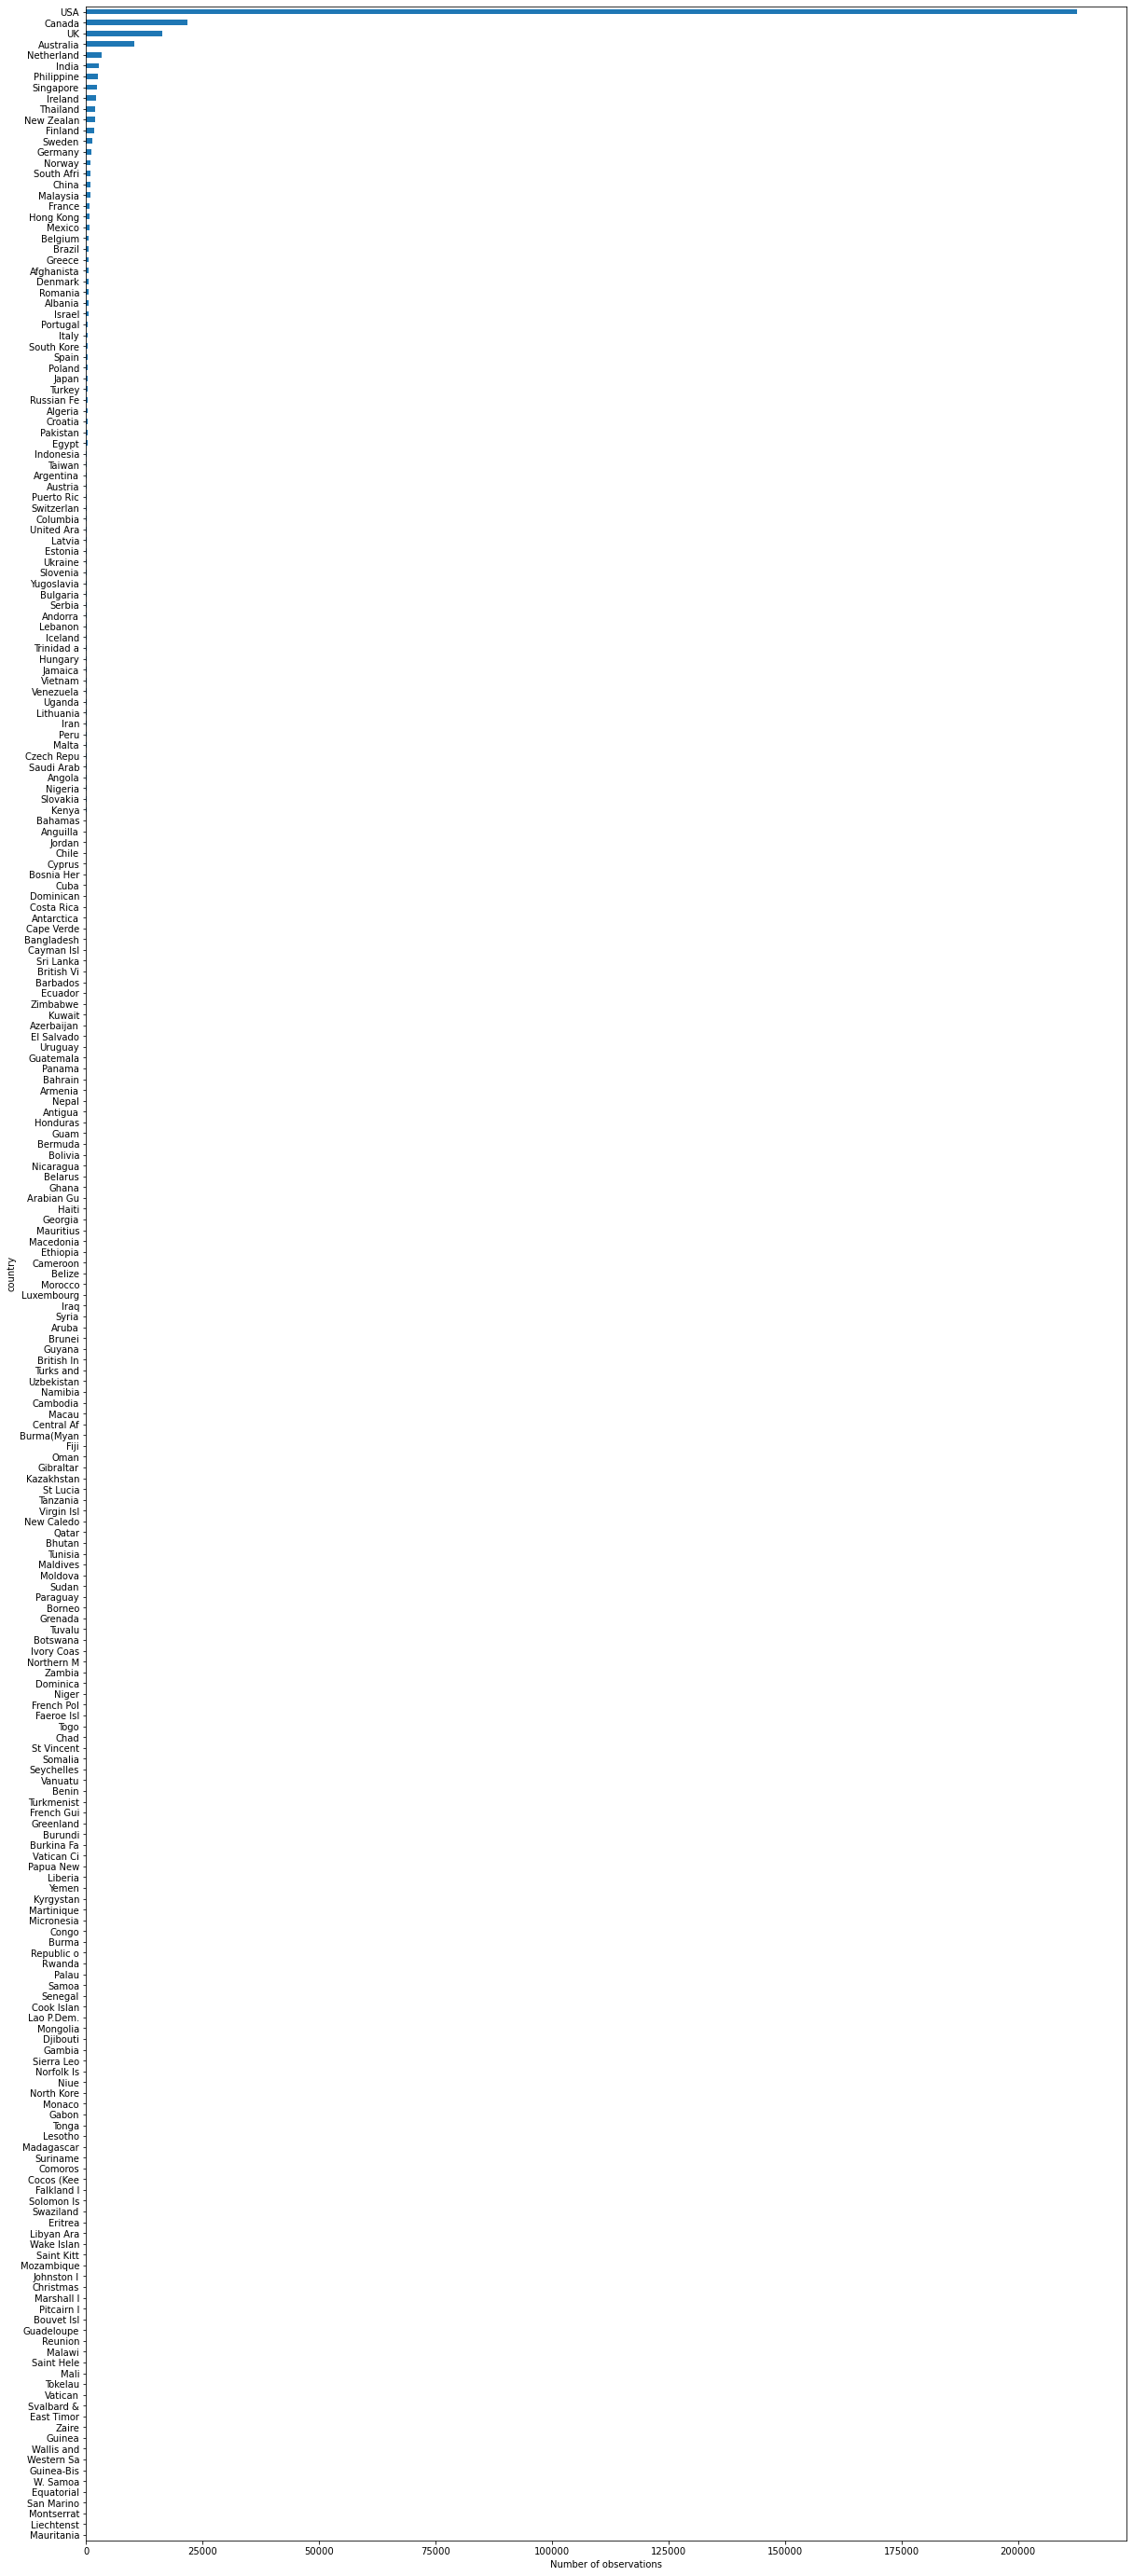

In [43]:
country = data.groupby(['country'])['age'].count().sort_values(ascending=True)
_=country.plot(kind='barh', figsize=(20,50))
_=plt.xlabel("Number of observations")

### Conclusions from the data exploratory:

Gender: The data is not balanced, there are more female observations than male.

Age: Most of the surveys are of young people in their twenties. It's not represent the world's population.

Countries: only 12 countries has more than 0.5% of the observations, and USA has a big advantage (69% of the observations).

Personality traits: The distribution of neuroticism and agreeable is a highr for femal than for male.

# Preprocessing

according to the exploratory data analysis we decided to:
1. balance the data (gender)
2. use only observations from countries with significant amount of survey (more than 0.5%)
3. Normalize the data

we decided to divide the process to three, using different data and comparing the results:
1. raw_data: the original data without NaN and only with significant countries one-hot encoding
2. balanced_data: raw_data downsampled to match populations' gender distribution
3. balanced_interacted_data: balanced_data with feature interaction

### raw data

Narrow countries to only ones with more than significant percent of the data.


In [ ]:
data_lenght = len(data)
significant_percent = 0.005
significant_observations = significant_percent * data_lenght
country[country > significant_observations]

In [ ]:
country_list = country[country > significant_observations].index.values.tolist()

Build Dataframes of chosen country binary variables and join with data 

In [ ]:
countries = pd.get_dummies(data['country'][data['country'].isin(country_list)])
data_country = pd.concat([data, countries] ,axis=1)
data_country.insert(20, 'Other', np.where(np.isnan(data_country['UK'].values), 1, 0)) #add 'other' country column
raw_data = data_country.fillna(0).drop(['country'], axis=1)

In [ ]:
raw_data.head()

In [ ]:
#Normalize features
scaler = MinMaxScaler()
names = raw_data.columns
d = scaler.fit_transform(raw_data)
scaled_raw_data = pd.DataFrame(d, index=raw_data.index, columns=names)

### spliting the data to train and test 

In [ ]:
target_name = 'sex'
scaled_raw_train, scaled_raw_test = train_test_split(scaled_raw_data)

In [ ]:
scaled_raw_train.info()

In [ ]:
scaled_raw_test.info()

### balanced_data

there are 50.5% men i the world, and 49.5% females in the world (https://countrymeters.info/en/World) The original data containes 60.26% female's surveys and 39.74% male's surveys we'll try to oversample and undersample our data

In [ ]:
minority_class = scaled_raw_train['sex'].value_counts()[0]
print(f"The scaled_raw_train data containes {(scaled_raw_train['sex'].value_counts()[1])} female's surveys and {(scaled_raw_train['sex'].value_counts()[0])} male's surveys")

In [ ]:
# Shuffle the Dataset.
shuffled_df = scaled_raw_train.sample(frac=1,random_state=4)

# Put all the male class in a separate dataset.
male_df = shuffled_df.loc[shuffled_df['sex'] == 0] #0= male, 1= female

#Randomly select minority_class number observations from the female (majority class)
female_df = shuffled_df.loc[shuffled_df['sex'] == 1].sample(n=minority_class,random_state=42)

# Concatenate both dataframes again
balanced_train = pd.concat([male_df, female_df])

#plot the dataset after the undersampling
plt.figure(figsize=(8, 8))
sns.countplot('sex', data=balanced_train)
plt.title('Balanced Classes')
plt.show()

### balanced_interacted_data

add interactions columns of personality traits

In [ ]:
Personality_Traits_list = ['agreeable_score', 'extraversion_score', 'openness_score', 'conscientiousness_score', 'neuroticism_score']

In [ ]:
#Run on Personality_Traits and multiply scores of any two pairs
def feature_interactions(data: pd.DataFrame, Personality_Traits_list: list):
    """
    multiply any two columns of Personality_Traits and save the result in a new column.

    Parameters
    ---------
    data: pd.DataFrame
    Personality_Traits_list: list
        Features's list of Personality_Traits
    
    return 
    """
    interacted_data = data.copy()
    i = 0
    j = i+1
    while i < (len(Personality_Traits_list)-1):
        new_feature = Personality_Traits_list[i] + '*' + Personality_Traits_list[j]
        interacted_data[new_feature] = interacted_data[Personality_Traits_list[i]] * interacted_data[Personality_Traits_list[i]]
        j = j+1
        if j == len(Personality_Traits_list):
            i= i+1
            j=i+1
    return interacted_data

In [ ]:
balanced_interacted_train = feature_interactions(balanced_train, Personality_Traits_list)
interacted_test = feature_interactions(scaled_raw_test, Personality_Traits_list) #the test data was not balanced, we only add the interaction columns

In [ ]:
balanced_interacted_train

In [ ]:
interacted_test

in the preprocessing we also tried:
K-Mean, outliers handeling and PCA
but eventually decided not to use them, because it didn't help the prediction

In [ ]:
#PCA
def pca_plot(data: pd.DataFrame, features: list, color_col: str ="sex"):
    """
    Plots the PCA as desired. 

    Parameters
    ---------
    data: pd.DataFrame
    features: list
        Features's list that we would like to reduce dimension
    ax_i: plt.axes
    color_col: str
        name of column to color the dots by.
    """
    x_only = data_country[features]

    pca_model = make_pipeline(StandardScaler(), PCA(n_components=2))
    pca_model.fit(x_only)

    X_2D = pca_model.transform(x_only)
    pca_dict = dict(PCA1=X_2D[:, 0], PCA2=X_2D[:, 1])
    pca_results = pd.DataFrame(pca_dict)

    color_series = data.loc[:, (color_col)].reset_index(drop=True)

    pca_results["color"] = color_series

    g = sns.scatterplot(data=pca_results, x="PCA1", y="PCA2", hue="color")
    g.legend_.remove()
    g.set(title=f"PCA of {features} colored by {color_col}")
_=pca_plot(scaled_raw_data, Personality_Traits_list)
hide_toggle('PCA')

In [ ]:
#Kmeans
Kmeans = KMeans(n_clusters=3)
Kmeans.fit(scaled_raw_data[Personality_Traits_list])
y_km = Kmeans.fit_predict(scaled_raw_data[Personality_Traits_list])
new_series = pd.Series(y_km, index=scaled_raw_data.index, name='cluster')
scaled_raw_data_Kmeans = pd.concat([scaled_raw_data, new_series] ,axis=1)
#Evaluation of the cluster result 
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).median()
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).count()
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).mean()
scaled_raw_data_Kmeans.groupby(by=["cluster", "sex"]).sum()
hide_toggle('Kmeans')

In [ ]:
train_datasets = [scaled_raw_train, balanced_train, balanced_interacted_train]

# Models

we tried few models (Logistic regression, Linear regression, Decision trees, Gradient Boosting).
the best results were given by Logistic regression and  Gradient Boosting, we will show them here:

### Logistic regression

In [ ]:
target_name = 'sex'

models_list = []
X_test_list = []
y_test_list = []
y_predicted_list = []
datasets_names = ['scaled_raw', 'balanced', 'balanced_interacted']

run on all 3 datas with Logistic regression:

In [ ]:
for train_data in train_datasets:
    
    #split train and test to X and y:
    X_train = train_data.drop(columns=[target_name])
    y_train = train_data[target_name].copy()   
    #fit the model according to train data
    Lreg = LogisticRegression(max_iter=100000).fit(X_train, y_train)
    #save model to model list
    models_list.append(Lreg)
    
    #different kind of test data because of the added columns
    if (train_data.equals(balanced_interacted_train)):

        X_test = interacted_test.drop(columns=[target_name])
        y_test = interacted_test[target_name].copy()   
    else:
        #first two options
        X_test = scaled_raw_test.drop(columns=[target_name])
        y_test = scaled_raw_test[target_name].copy()   
        
    X_test_list.append(X_test)
    y_test_list.append(y_test)

    
    #predict 
    y_predicted = Lreg.predict(X_test)
    y_predicted_list.append(y_predicted)
    

In [ ]:
models_list

In [ ]:
y_predicted_list

Plot results for 3 datas:

In [ ]:
target_names = ['Male', 'Female']
for i in range(len(train_datasets)):
    print("Plots for ", datasets_names[i])
    _ = plot_roc_curve(models_list[i], X_test_list[i], y_test_list[i])
    report = classification_report(y_test_list[i], y_predicted_list[i], target_names=target_names)
    print(report)
    disp = plot_confusion_matrix(models_list[i],
                                 X_test_list[i],
                                 y_test_list[i],
                                 display_labels=['Male', 'Female'],
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    plt.show()

    

### Gradient Boosting

run on all 3 datas with Gradiant Boosting:

In [ ]:
models_list_GB = []
y_predicted_list_GB = []
X_train_list = []

In [ ]:
for train_data in train_datasets:
    
    #split train and test to X and y:
    X_train = train_data.drop(columns=[target_name])
    y_train = train_data[target_name].copy()   
    X_train_list.append(X_train)
    #fit the model according to train data
    gradient_boosting  = GradientBoostingClassifier(random_state =0).fit(X_train, y_train)
    #save model to model list
    models_list_GB.append(gradient_boosting)
    
    #different kind of test data because of the added columns
    if (train_data.equals(balanced_interacted_train)):

        X_test = interacted_test.drop(columns=[target_name])
        y_test = interacted_test[target_name].copy()   
    else:
        #first two options
        X_test = scaled_raw_test.drop(columns=[target_name])
        y_test = scaled_raw_test[target_name].copy()   
        
    #predict 
    y_predicted = gradient_boosting.predict(X_test)
    y_predicted_list_GB.append(y_predicted)

Plot results for 3 datas:

In [ ]:
for i in range(len(train_datasets)):
    print("Plots for ", datasets_names[i])
    _ = plot_roc_curve(models_list[i], X_test_list[i], y_test_list[i])
    report = classification_report(y_test_list[i], y_predicted_list[i], target_names=target_names)
    print(report)
    disp = plot_confusion_matrix(models_list[i],
                                 X_test_list[i],
                                 y_test_list[i],
                                 display_labels=['Male', 'Female'],
                                 cmap=plt.cm.Blues,
                                 normalize="true")
    plt.show()

the most significant change was balancing the data, it improved the male prediction.
if the female's recall is more important than the man's recall - the first data will be preferable.

# Explainability

### Logistic Regression model - explainability

In [ ]:
def explainability_Logistic_Regression (coef: np.array, delta: float):
    value = []
    for i in range(coef.shape[1]):
        value.append(exp(Lreg.coef_[0][i]*delta))
    return value

In [ ]:
for i in range(len(models_list)):
    coef = models_list[i].coef_
    Explainability = explainability_Logistic_Regression(coef, 0.3) #delta is positive - probability for femal
    Explainability_df = pd.Series(np.array(Explainability),  index=X_test_list[i].columns.to_list(), name='Explainability')
    _=Explainability_df.nlargest(20).sort_values().plot(kind='barh')
    plt.show()

### Gradient Boosting model - Shap explainability

In [ ]:
for i in range(len(models_list)):
    explainer = shap.Explainer(models_list_GB[i])
    shap_values = explainer(X_train_list[i])
    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)
    plt.show()
